# LT2 Footbridge acceleration datasets

This notebook provides information about acceleration datasets collected from the LT2 footbridge at the University of Edinburgh. This data was collected as part of a one-day monitoring campaign to understand the dynamic behaviour of the bridge, insights from which were used in the design and installation of the [LT2 Smarter Bridge](https://smarterbridge.herokuapp.com/).

## Accessing the data
Selected data from the one-day monitoring of the LT2 Footbridge are linked below:

- [Pedestrian-only bridge acceleration data](_static/LT2_Bridge_unloaded.csv) - Acceleration data from the LT2 footbridge during excitation of the empty bridge by a single pedestrian (csv file).
- [Pedestrian with additional static mass bridge acceleration data](_static/LT2_Bridge_60kg_load.csv) - Acceleration data from the LT2 footbridge during excitation of the bridge by a single pedestrian when a static 60kg mass is added to the bridge (csv file).
- [Co-ordinates of accelerometers](_static/LT2_co_ords.csv) - Co-ordinates of bridge accelerometers (csv file).


## Description of structure
The LT2 footbridge connects a cafe and a lecture theatre at the Kings Buildings campus of the University of Edinburgh. It's a box-truss bridge spanning approximately 10.8 metres, with the pedestrian walkway fully enclosed. Photos of the bridge and testing setup are shown below.

<div><center>
<img src="_static/LT2_01.JPG" width="45%"/>
<img src="_static/LT2_02.JPG" width="45%"/>
</center></div>

## Sensor network

Tri-axial accelerometers were located at floor level inside the bridge at the locations shown in the plot below. Accelerometers were temporarily fixed to the main truss structure of the bridge.

Text(0, 0.5, 'Y co-ordinate [m]')

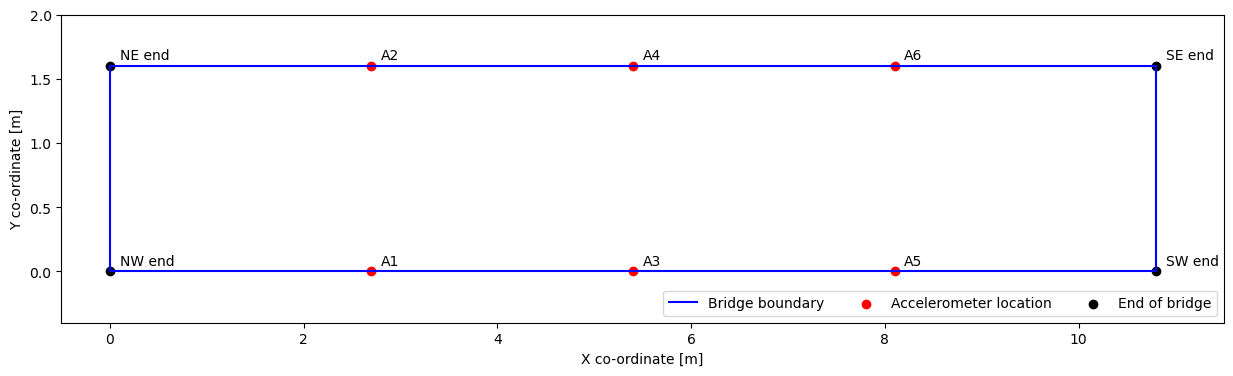

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
url = "https://edacab.readthedocs.io/en/latest/Welcome_page_and_tutorials/_static/LT2_co_ords.csv"

co_ords = pd.read_csv(url)
fg,ax = plt.subplots(figsize=(15,4))
ax.plot([0,10.8,10.8,0,0],[1.6,1.6,0,0,1.6],c='b',label='Bridge boundary')
ax.scatter(co_ords['X'].iloc[:-4],co_ords['Y'].iloc[:-4],c='r',label='Accelerometer location')
ax.scatter(co_ords['X'].iloc[-4:],co_ords['Y'].iloc[-4:],c='k',label='End of bridge')

ax.legend(loc=4,ncol=3)

for i in range(len(co_ords)):
    ax.annotate(co_ords['Loc'].iloc[i], (co_ords['X'].iloc[i]+0.1,co_ords['Y'].iloc[i]+0.05))
ax.set_ylim(-0.4,2)
ax.set_xlim(-0.5,11.5)
ax.set_xlabel('X co-ordinate [m]')
ax.set_ylabel('Y co-ordinate [m]')

## Data collection and experimental regime
All acceleration datasets were collected at a sample rate of 1707.7Hz. To help with accessing the data from Jupyter Notebooks, the data has been lowpass filtered using a Butterworth filter at 40Hz, highpass filtered using a Butterworth filter at 1Hz, and then downsampled to a sample rate of 170.77Hz. All data is saved as CSV files and provided in units of $m/s^2$.

## Accessing the data

### Loading the footbridge datasets
Let's start by accessing the data for the period where the bridge was loaded by a single pedestrian. The data is hosted on GitHub and can be accessed via the URL shown below.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

url = "https://edacab.readthedocs.io/en/latest/Welcome_page_and_tutorials/_static/LT2_Bridge_unloaded.csv" # URL of data for when bridge is loaded by a single pedestrian

data = pd.read_csv(url,index_col=0,parse_dates=True) # Load the data from the .csv file to a Pandas dataframe
fs = 170.77 # Sampling frequency of data in Hz

### Exploring the footbridge datasets
The data is organized with each column of the dataframe being the output from an accelerometer channel. The names of the accelerometer channels are shown below. The first two values of each accelerometer channel name correspond to the accelerometer location plotted in the previous section. The last value of the accelerometer channel name is the direction of movement: Z corresponds to vertical acceleration responses, X corresponds to transverse acceleration responses.

In [3]:
print(data.columns) # Print the name of the accelerometer channels (the column headings in the dataframe)

Index(['A2Z', 'A2X', 'A5X', 'A5Z', 'A3X', 'A3Z', 'A1Z', 'A1X', 'A6X', 'A6Z',
       'A4X', 'A4Z'],
      dtype='object')


### Plotting the footbridge datasets
#### Raw data plots
Let's plot some of the raw acceleration output for accelerometer channel A2Z. In the plotted data we can see each of the pedestrian crossings. These crossings were from a single pedestrian walking at a variety of speeds and following various crossing paths.

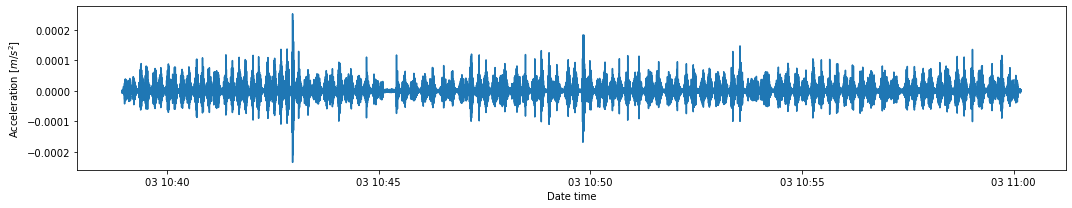

In [4]:
fg,ax = plt.subplots(figsize=(15,3))
ax.plot(data['A2Z'])
ax.set_ylabel('Acceleration [$m/s^2$]')
ax.set_xlabel('Date time')
fg.tight_layout()

#### Plotting Welch power spectral density
Now let's plot the 30-second Welch averaged power spectral density of each accelerometer channel. We can see that the dynamic behaviour of the bridge is complex, with many peaks in the frequency spectra. We can also see that the data is slightly corrupted by the 50Hz electrical mains signal alongside the frequency roll-off due to filtering and downsampling of the data.

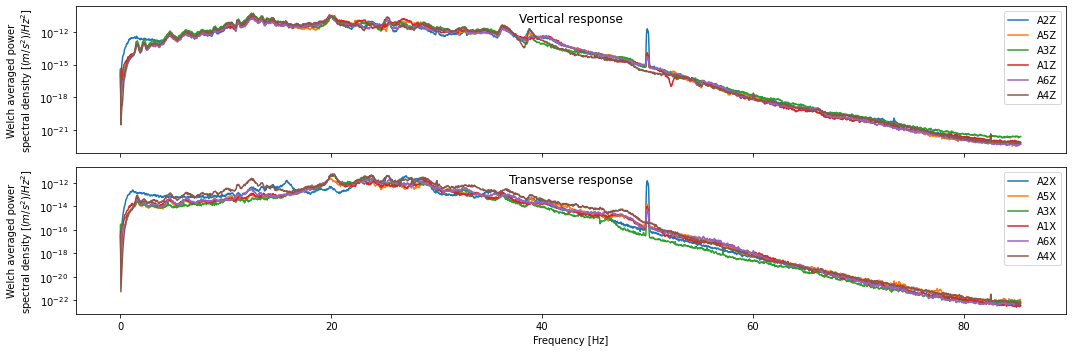

In [5]:
from scipy.signal import welch

fg,ax = plt.subplots(2,sharex='all',figsize=(15,5)) # Create an empty plot with two subplots that share an x-axis

# Cycle through all columns of dataframe and calculate Welch power spectral density and plot it
for channel in data.columns:
    f,psd = welch(data[channel],fs=fs,nperseg=30*fs) # Calculate 30 second Welch power spectral density (PSD)

    if "Z" in channel:
        ax[0].semilogy(f[1:],psd[1:],label=channel) # Plotting vertical acceleration PSDs in top plot
    else:
        ax[1].semilogy(f[1:],psd[1:],label=channel) # Plotting transverse acceleration PSDs in lower plot
ax[0].set_title('Vertical response',y=0.85) # Set title for top plot
ax[1].set_title('Transverse response',y=0.85) # Set title for lower plot
ax[0].set_ylabel('Welch averaged power\nspectral density [$(m/s^2)/Hz^2$]') # Label y-axis of top plot
ax[1].set_ylabel('Welch averaged power\nspectral density [$(m/s^2)/Hz^2$]') # Label y-axis of lower plot
ax[1].set_xlabel('Frequency [Hz]') # Label x-axis of lower plot
ax[0].legend(loc=1) # Add a legend to top plot
ax[1].legend(loc=1) # Add a legend to lower plot
fg.tight_layout() # Remove any unnecessary white space from plot

#### Extracting and plotting modal parameters and mode shapes
Now let's form some mode shapes. To form the mode shapes we're going to form correlation functions of the data, taking accelerometer A2Z as our reference channel. We're only going to use the vertical data when forming these mode shapes, as transverse movement of the bridge is very small!

We'll start by reloading the data, sorting it and removing the transverse datasets we don't need.

In [6]:
url = "https://edacab.readthedocs.io/en/latest/Welcome_page_and_tutorials/_static/LT2_Bridge_unloaded.csv"
# Load data from URL
data = pd.read_csv(url,index_col=0,parse_dates=True)

# Sort the columns of the pandas dataframe alphabetically
data.sort_index(axis=1,inplace=True)

# Sample rate of data
fs = 170.77

# Only interested in vertical mode shapes so we'll remove the transverse datasets
for col in data.columns:
    if "Z" not in col:
        data.drop(col,axis=1,inplace=True)

Next we'll form 3-second correlation functions of the data, taking accelerometer A2Z as our reference channel.

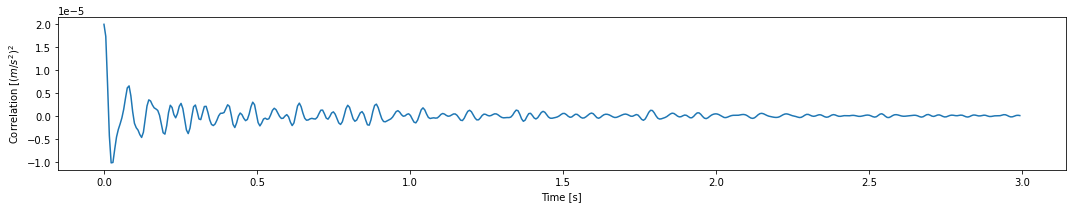

In [7]:
# Length of correlation function to use
seg_l = int(3*fs)
# Time array used for plotting correlation function
seg_t = np.arange(0,seg_l/fs,1/fs)
# The trigger is the reference accelerzometer we'll use to form the correlation function
trigger = 'A2Z'
# Form the correlation functions for each dataset
corr = np.array([np.correlate(data[trigger],data[channel][:-seg_l+1],mode='valid') for channel in data.columns])
# Plot the cross-correlation function for A1Z and A2Z
fg,ax = plt.subplots(figsize=(15,3))
ax.plot(seg_t,corr[0])
ax.set_xlabel('Time [s]')
ax.set_ylabel('Correlation [$(m/s^2)^2$')
fg.tight_layout()


We'll estimate the modal parameters from the correlation functions using the Matrix Pencil Method as it's robust to noise. For an overview of the matrix pencil method see this [paper](https://doi.org/10.1109/74.370583). Note, in the code below we're excluding the first two points of each correlation function, as this is usually [corrupted with the auto-correlation of the noise and forcing within the data](https://doi.org/10.1002/stc.2970), and we're incrementing the model order until the fit between our order-K approximated correlation function achieves a target [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) ($R^2$ score) of 0.95.

In [8]:
from scipy import linalg
from sklearn.metrics import r2_score

def matrix_pencil_method(y,fs,K_min,K_max,r2_targ = 0.99,n_excl=0,dataset = 0,trigger = 0, imp=0):
    """
    Implementation of Matrix Pencil organized for use with Pandas.
    Calculates fitted signals for multiple model orders between K_min and K_max
    assuming correlation function is comprised of free-decays of a linear system. Model order
    incremented until R2 target is met.

    Parameters
    ----------
    y : 1D Numpy array
        Correlation function to be analysed.
    fs : float
        Sample rate (Hz) of data.
    K_min : Int
        Minimum model order to use for fitting of correlation function.
    K_max : Int
        Maximum model order to use for fitting of correlation function.
    r2_targ = float
        Target explained variance to iterate to achieve, based on R2 score (coefficient of determination)
    n_excl : Int, optional
        Number of samples WHICH HAVE ALREADY BEEN excluded from the start of the correlation function.
        Used to account for excluded values in calculation of phase angle. The default is 0.
    dataset : Int, optional
        The reference number for the accelerometer . The default is 0.
    trigger_dataset : Int, optional
        The reference number for the accelerometer used as the trigger channel
        for generation of correlation function. The default is 0.
    timestep : Int, optional
        Reference number for timestep relative to start of dataset. The default is 0.

    Returns
    -------
    modal_est : Pandas dataframe
        Array containing modal estimates and key tracking data. From left to right the
        columns are: Timestep, trigger dataset, dataset, natural frequency (Hz),
        damping (% of critical), amplitude (relative), phase (radians), normalized amplitude
        (amplitude divided by maximum amplitude of correlation function), R2 score.

    """
    # Form hankel matrix
    N = len(y)
    ind = np.arange(N) + n_excl
    ls=int(np.floor(N/3))
    c = y[:N-ls]
    r = y[N-ls-1:N]
    X = linalg.hankel(c,r)
    # Application of singular value decomposition
    U, S, V = linalg.svd(X[:,1:ls+1], full_matrices=False)

    # Calculate number of modal estimates to be generated using triangular numbers
    # formula
    n_terms = int(((K_max*(K_max+1))/2)-((K_min*(K_min-1))/2))

    # Initiate empty modal estimates array
    modal_est = np.zeros((n_terms,10))
    modal_est[:,0] = dataset # Column 0 = Timestep
    modal_est[:,1] = trigger # Column 1 = Triggering dataset
    modal_est[:,2] = imp # Column 2 = Dataset
    y_rd = np.zeros((K_max-K_min+1,len(y)))
    n = 0 # n used as a counter
    nk=0 # Used as a counter
    K = K_min
    r2 = 0
    while (K<=K_max) and (r2<r2_targ):

        modal_est[n:n+K,3] = K # Column 3 = Model order
        # We use try/except as the pseudo-inverse will occasionally fail
        try:
            # Use eigenvalues to calculate modal parameters of singular values
            p = np.log(linalg.eigvals(np.diag(1./S[:2*K]).dot((U[:,:2*K].T.dot(X[:,:ls])).dot(np.transpose(V)[:,:2*K]))))
            # Seperate eigenvalue into frequency and damping
            Om = np.imag(p)
            D = np.real(p)
            # Generate an array containing components of RDS
            Z=np.exp((-D.reshape(-1,1)*(ind))+(complex(0,1)*Om.reshape(-1,1)*(ind)))/2
            # Exclude zero values due to underflow errors
            Om = Om[np.max(abs(Z),axis=1)<1e5]
            D = D[np.max(abs(Z),axis=1)<1e5]
            Z = Z[np.max(abs(Z),axis=1)<1e5]
            # Use pseudoinverse to calculate amplitude and phase of components of RDS
            R = np.array(np.linalg.pinv(Z.T)*np.matrix(y).H).squeeze()
            y_f =np.sum(np.real(Z*R.reshape(-1,1)),axis=0)
            y_rd[nk] = y_f
            # Sort frequency according to frequency, keep only the first half of results
            # Note: This is similiar to keeping only positive results but with overfitting of signal
            # the number of positive and negative components may no longer be equal
            # Also ensures that the correct number of components are always taken
            indx = np.argsort(Om)[::-1][:K]
            modal_est[n:n+K,4] = Om[indx] # Column 4 = Natural frequency (radians)
            modal_est[n:n+K,5] = D[indx]/modal_est[n:n+K,4] # Column 5 = Damping (fraction of critical damping) - We have to scale relative to the natural frequency
            modal_est[n:n+K,6] = np.abs(R)[indx] # Column 6 = Amplitude of component
            modal_est[n:n+K,7] = np.angle(R)[indx] # Column 7 = Phase of component
            modal_est[n:n+len(indx),9] = r2_score(y,y_f)
            r2 = modal_est[n,9]
        except:
            0
        n+=K
        K+=1
        nk+=1
    modal_est[:,8] = modal_est[:,6]/np.max(abs(y)) # Column 8 = Normalized amplitude (divide by max absolute amplitude of RDS)
    modal_est[:,4]=modal_est[:,4]*fs/(2*np.pi) # Convert frequency from radians to Hz
    modal_est[:,5] = modal_est[:,5]*100 # Convert damping from fraction to percentage of critical damping

    headers = ['Dataset','Trigger Accelerometer','Impact','Model order','Frequency','Damping',
               'Amplitude','Phase','Normalized amplitude','R2 Score']
    modal_est = pd.DataFrame(data=modal_est,columns=headers)
    return modal_est

# Estimate modal parameters of correlation functions.
modal_params = pd.concat([matrix_pencil_method(corr[i,2:], fs, 1, 20,n_excl=2,dataset=i,r2_targ=0.95) for i in range(len(corr))])
modal_params = modal_params.loc[modal_params['R2 Score']>=0.95]


Now let's plot the frequency and damping ratios estimated for each of the correlation functions.

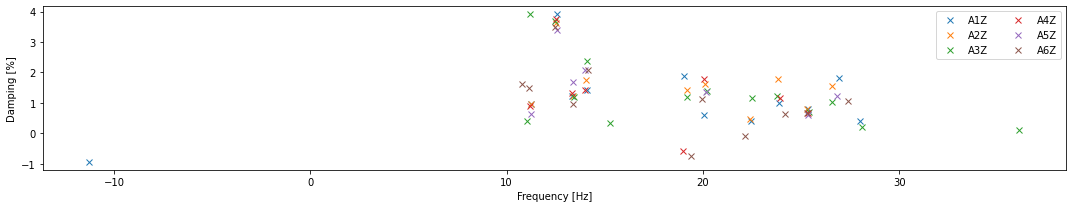

In [9]:
# Plot scatter of modal parameters
fg,ax = plt.subplots(figsize=(15,3))
for i in range(len(corr)):
    ax.plot(modal_params.loc[modal_params['Dataset']==i]['Frequency'],
               modal_params.loc[modal_params['Dataset']==i]['Damping'],'x',label=data.columns[i])
ax.set_ylabel('Damping [%]')
ax.set_xlabel('Frequency [Hz]')
ax.legend(loc=1,ncol=2)
fg.tight_layout()

We'll start by focusing in on the clusters of modal estimates between 9Hz and 17Hz.

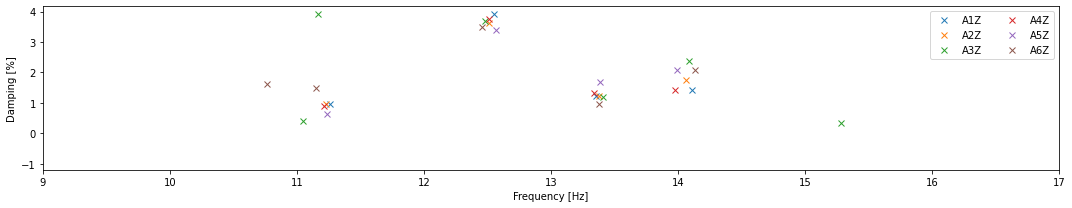

In [10]:
# Plot scatter of modal parameters between 9Hz and 17Hz
fg,ax = plt.subplots(figsize=(15,3))
for i in range(len(corr)):
    ax.plot(modal_params.loc[modal_params['Dataset']==i]['Frequency'],
               modal_params.loc[modal_params['Dataset']==i]['Damping'],'x',label=data.columns[i])
ax.set_ylabel('Damping [%]')
ax.set_xlabel('Frequency [Hz]')
ax.legend(loc=1,ncol=2)
ax.set_xlim(9,17)
fg.tight_layout()

There's a tight cluster of estimates between 12Hz and 13Hz which we'll use for demonstrating the mode shape generation. To generate the mode shape we'll extract the amplitude at each accelerometer location, correct it for the phase direction (whether the movement is in-phase or out-of-phase with the reference accelerometer), and then use cubic interpolation across the length of the bridge assuming no movement at the ends of the bridge.

In [11]:
from scipy.interpolate import griddata
pd.options.mode.chained_assignment = None  # Used to suppress the pandas warning for operations on dataframes

# Set some frequency limits to extract the mode between 12Hz and 13Hz
frq_limits = [12,13]
modal_params_in_frq_limits = modal_params.loc[(modal_params['Frequency']>frq_limits[0]) & 
                                              (modal_params['Frequency']<frq_limits[1])]
# Let's combine the phase and amplitude information so that components that are out of phase have an amplitude of -1
ph_direc = np.ones(len(modal_params_in_frq_limits))
ph_direc[abs(modal_params_in_frq_limits['Phase'])>np.pi/2]=-1
modal_params_in_frq_limits.loc[:,'Amplitude'] = modal_params_in_frq_limits['Amplitude'].values*ph_direc

# Now lets form the mode shape
ms = np.array(modal_params_in_frq_limits.groupby('Dataset').mean()['Amplitude'])

# Let's generate a grid for interpolating the mode shape
xi = np.arange(np.min(co_ords['X']),np.max(co_ords['X'])+0.01,0.01)
yi = np.arange(np.min(co_ords['Y']),np.max(co_ords['Y'])+0.01,0.01)
xi,yi = np.meshgrid(xi,yi)

# We need to append an amplitude of zero at the ends of the bridge
ms = np.hstack((ms,np.zeros(4)))

# We'll normalize out mode shape to have a maximum absolute amplitude of 1
ms = ms/np.max(abs(ms))

# Now we'll use cubic interpolation to generate our mode shape across the grid
mode_shape = griddata(co_ords[['X','Y']],ms,
                      np.vstack((xi.ravel(),yi.ravel())).T,method='cubic'
                      ).reshape(len(xi),len(xi[0]))

We can now plot our interpolated mode shape for the mode between 12Hz and 13Hz!

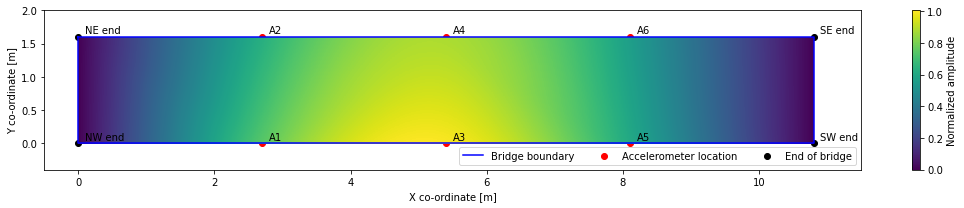

In [12]:
# Now let's plot our mode shape
fg,ax = plt.subplots(figsize=(15,3))
ax.plot([0,10.8,10.8,0,0],[1.6,1.6,0,0,1.6],c='b',label='Bridge boundary')
ax.scatter(co_ords['X'].iloc[:-4],co_ords['Y'].iloc[:-4],c='r',label='Accelerometer location')
ax.scatter(co_ords['X'].iloc[-4:],co_ords['Y'].iloc[-4:],c='k',label='End of bridge')
cb = ax.pcolormesh(xi,yi,mode_shape)
cbar = fg.colorbar(cb)
cbar.ax.set_ylabel('Normalized amplitude')
ax.legend(loc=4,ncol=3)

for i in range(len(co_ords)):
    ax.annotate(co_ords['Loc'].iloc[i], (co_ords['X'].iloc[i]+0.1,co_ords['Y'].iloc[i]+0.05))
ax.set_ylim(-0.4,2)
ax.set_xlim(-0.5,11.5)
ax.set_xlabel('X co-ordinate [m]')
ax.set_ylabel('Y co-ordinate [m]')
fg.tight_layout()


We can repeat this process when generating the mode shape for any cluster of modal results of interest. The code below produces mode shapes for a range of frequency limits using the generate_mode_shape function.

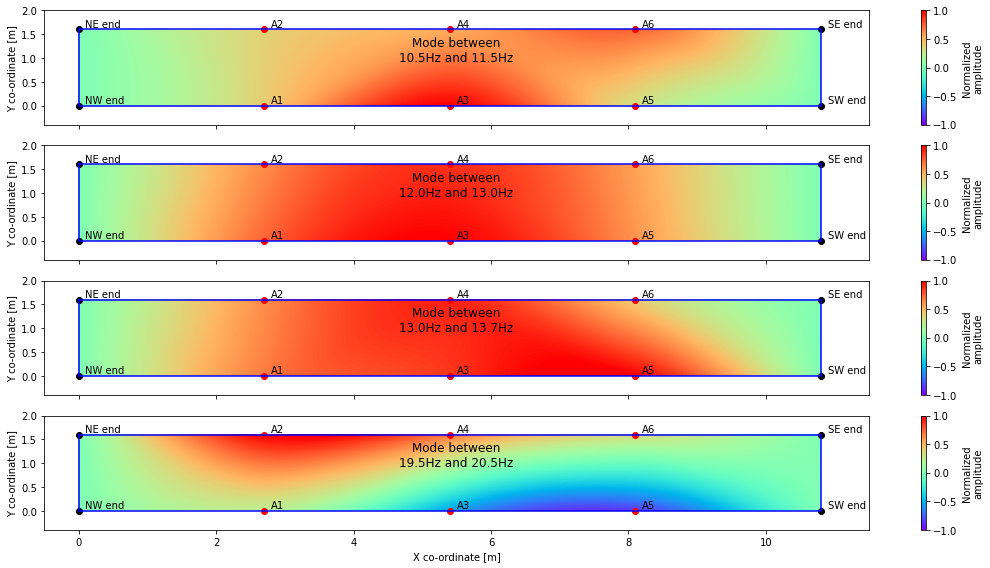

In [13]:
def generate_mode_shape(modal_params,frq_limits,xi,yi):
    modal_params_in_frq_limits = modal_params.loc[(modal_params['Frequency']>frq_limits[0]) & 
                                              (modal_params['Frequency']<frq_limits[1])]
    ph_direc = np.ones(len(modal_params_in_frq_limits))
    ph_direc[abs(modal_params_in_frq_limits['Phase'])>np.pi/2]=-1
    modal_params_in_frq_limits.loc[:,'Amplitude'] = modal_params_in_frq_limits['Amplitude'].values*ph_direc
    ms = np.array(modal_params_in_frq_limits.groupby('Dataset').mean()['Amplitude'])
    ms = np.hstack((ms,np.zeros(4)))
    ms = ms/np.max(abs(ms))
    mode_shape = griddata(co_ords[['X','Y']],ms,
                          np.vstack((xi.ravel(),yi.ravel())).T,method='cubic'
                          ).reshape(len(xi),len(xi[0]))
    return mode_shape

xi = np.arange(np.min(co_ords['X']),np.max(co_ords['X'])+0.01,0.01)
yi = np.arange(np.min(co_ords['Y']),np.max(co_ords['Y'])+0.01,0.01)
xi,yi = np.meshgrid(xi,yi)

fg,ax = plt.subplots(4,sharex='all',sharey='all',figsize=(15,8))

ax[0].set_title('Mode between\n10.5Hz and 11.5Hz',y=0.5)
cb=ax[0].pcolormesh(xi,yi,generate_mode_shape(modal_params,[10.5,11.5],xi,yi),vmin=-1,vmax=1,cmap='rainbow')
cbar = fg.colorbar(cb,ax=ax[0])
cbar.ax.set_ylabel('Normalized\namplitude')

ax[1].set_title('Mode between\n12.0Hz and 13.0Hz',y=0.5)
cb=ax[1].pcolormesh(xi,yi,generate_mode_shape(modal_params,[12,13],xi,yi),vmin=-1,vmax=1,cmap='rainbow')
cbar = fg.colorbar(cb,ax=ax[1])
cbar.ax.set_ylabel('Normalized\namplitude')

ax[2].set_title('Mode between\n13.0Hz and 13.7Hz',y=0.5)
cb=ax[2].pcolormesh(xi,yi,generate_mode_shape(modal_params,[13,13.7],xi,yi),vmin=-1,vmax=1,cmap='rainbow')
cbar = fg.colorbar(cb,ax=ax[2])
cbar.ax.set_ylabel('Normalized\namplitude')

ax[3].set_title('Mode between\n19.5Hz and 20.5Hz',y=0.5)
cb=ax[3].pcolormesh(xi,yi,generate_mode_shape(modal_params,[19.5,20.5],xi,yi),vmin=-1,vmax=1,cmap='rainbow')
cbar = fg.colorbar(cb,ax=ax[3])
cbar.ax.set_ylabel('Normalized\namplitude')

for j in range(4):
    ax[j].plot([0,10.8,10.8,0,0],[1.6,1.6,0,0,1.6],c='b',label='Bridge boundary')
    ax[j].scatter(co_ords['X'].iloc[:-4],co_ords['Y'].iloc[:-4],c='r',label='Accelerometer location')
    ax[j].scatter(co_ords['X'].iloc[-4:],co_ords['Y'].iloc[-4:],c='k',label='End of bridge')
    ax[j].set_ylabel('Y co-ordinate [m]')
    for i in range(len(co_ords)):
        ax[j].annotate(co_ords['Loc'].iloc[i], (co_ords['X'].iloc[i]+0.1,co_ords['Y'].iloc[i]+0.05))
ax[-1].set_ylim(-0.4,2)
ax[-1].set_xlim(-0.5,11.5)
ax[-1].set_xlabel('X co-ordinate [m]')

fg.tight_layout()


We can see that all the first three modes are all very similiar, being of the form of a half sinusoid or first order mode. The fourth mode plotted is more interesting, being a second order torsional mode. 

#### Comparing unloaded and static loaded bridge behaviour
Also collected at the same time as data from the LT2 footbridge excited by a single pedestrian was acceleration data when there was a static load of 60kg located at various positions on the bridge. Identifying changes in dynamic behaviour of civil structures under loading is a useful excercise as these methods can be used to [identify damage to the structure](https://doi.org/10.1016/j.engstruct.2021.113745). Let's start by loading and plotting the data from when the bridge was loaded with the 60kg mass.

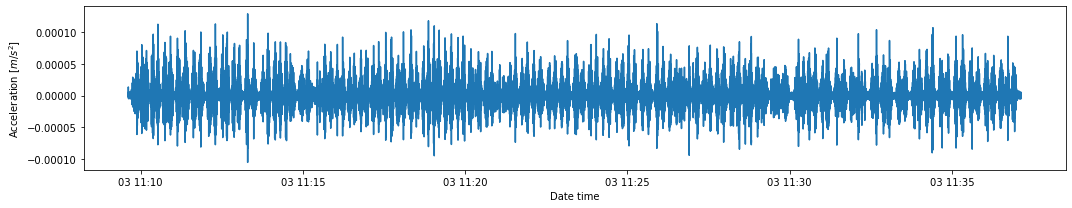

In [14]:
url = "https://edacab.readthedocs.io/en/latest/Welcome_page_and_tutorials/_static/LT2_Bridge_60kg_load.csv"

data_60kg = pd.read_csv(url,index_col=0,parse_dates=True)
fs = 170.77 # Sampling frequency in Hz

fg,ax = plt.subplots(figsize=(15,3))
ax.plot(data_60kg['A2Z'])
ax.set_ylabel('Acceleration [$m/s^2$]')
ax.set_xlabel('Date time')
fg.tight_layout()

During this period the 60kg mass is moved to a variety of locations along the bridge deck. If we reload the unloaded data and plot the Welch power spectral density of both datasets we can see how the additional 60kg mass impacts the natural frequencies and damping ratios of the structure.

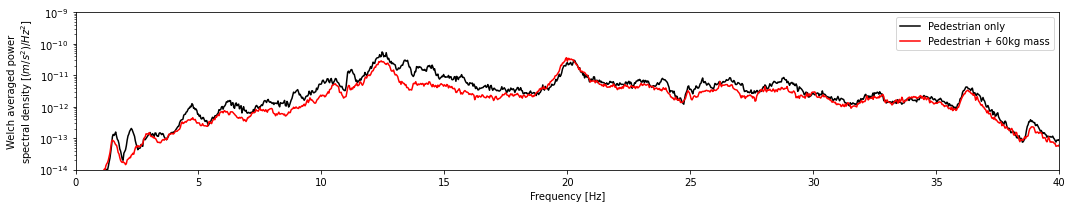

In [15]:
from scipy.signal import welch

url = "https://edacab.readthedocs.io/en/latest/Welcome_page_and_tutorials/_static/LT2_Bridge_unloaded.csv"

data = pd.read_csv(url,index_col=0,parse_dates=True)

f,psd_unloaded = welch(data['A3Z'],fs=fs,nperseg=30*fs)
f,psd_60kg_load = welch(data_60kg['A3Z'],fs=fs,nperseg=30*fs)

fg,ax = plt.subplots(figsize=(15,3))
ax.semilogy(f[1:],psd_unloaded[1:],'k',label='Pedestrian only')
ax.semilogy(f[1:],psd_60kg_load[1:],'r',label='Pedestrian + 60kg mass')
ax.set_ylabel('Welch averaged power\nspectral density [$(m/s^2)/Hz^2$]')
ax.set_xlabel('Frequency [Hz]')
ax.legend(loc=1)
ax.set_ylim(10e-15,10e-10)
ax.set_xlim(0,40)
fg.tight_layout()

The impact of the additional 60kg mass is very small, as the modal mass of the structure is much higher. Therefore we need more efficient methods of identifying when the 60kg mass is present on the bridge than visually comparing the Welch power spectral density. 